### Answerability Model
This Notebook contains data processing for an Answerability Model to determine if a Question can be answered from the given context

In [90]:
import pandas as pd
from transformers import AutoTokenizer
from nltk import tokenize
import numpy as np
import pickle
import transformers
import pandas as pd 
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer, util
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tfidf_vectorizer = TfidfVectorizer(stop_words ='english')
sentence_t = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [66]:
import datasets
from datasets import load_dataset

In [67]:
squad = load_dataset('squad_v2')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset squad_v2 downloaded and prepared to /Users/weihern/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [131]:
df = pd.concat([pd.DataFrame(squad['train']),pd.DataFrame(squad['validation'])])

In [132]:
master = df[['question','context','answers']].copy()
master.columns = ['Question','Context','Answers']
master['Answers'] = master['Answers'].apply(lambda x: len(x['text']) != 0)

In [133]:
master = master.drop_duplicates(subset=['Question'])
master = pd.concat([master[master['Answers'] == False].sample(3000),master[master['Answers'] == True].sample(3000)])

In [135]:
tfidf_vectorizer.fit(master['Question'].tolist() + master['Context'].tolist())

TfidfVectorizer(stop_words='english')

In [137]:
def add_features(df):
  #HELPERS
  def intersec(q,r):
    return len([x for x in q if x in r])
  
  def vectorize(text):
    return tfidf_vectorizer.transform([text]).toarray()[0]

  def tokenize(text):
    return tokenizer(text,max_length=512,truncation=True).get('input_ids')
  
  def sentenceTransform(text):
    return sentence_t.encode(text)

  def cosine_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))
  
  def dotproduct(a,b):
    return np.dot(a,b)
  
  def euclid_dist(a,b):
    return np.linalg.norm(a-b)
  
  def sentence_mean_max(model,q,r):
    f = dotproduct
    vals = [f(q,model(sentence)) for sentence in nltk.tokenize.sent_tokenize(r)]
    return pd.Series([np.mean(vals), np.max(vals)])

  df = df.copy()
  df['Question_ntokens'] = df['Question'].apply(lambda x:len(tokenize(x)))
  df['Context_ntokens'] = df['Context'].apply(lambda x:len(tokenize(x)))
  df['Question_tokens'] = df['Question'].apply(lambda x:tokenize(x))
  df['Context_tokens'] = df['Context'].apply(lambda x:tokenize(x))
  df['intersec'] = df.apply(lambda row: intersec(row['Question'], row['Context']),axis=1)
  df['intersec_pct'] = df['intersec'] / df['Question_ntokens']
  df['Question_encoded'] = df['Question'].apply(lambda x: sentenceTransform(x))
  df['Context_encoded'] = df['Context'].apply(lambda x: sentenceTransform(x))
  df['Question_tfidf'] = df['Question'].apply(lambda x: vectorize(x))
  df['Context_tfidf'] = df['Context'].apply(lambda x: vectorize(x))

  for m in ['encoded','tfidf']:
    df[f'cosine_sim_{m}'] = df.apply(lambda row: cosine_similarity(row[f'Question_{m}'], row[f'Context_{m}']),axis =1 )
    df[f'dot_prod_{m}'] = df.apply(lambda row: dotproduct(row[f'Question_{m}'], row[f'Context_{m}']),axis =1 )
    df[f'euclid_dist_{m}'] = df.apply(lambda row: euclid_dist(row[f'Question_{m}'], row[f'Context_{m}']),axis =1 )
  df[['sent_max_encoded','sent_mean_encoded']] = df.apply(lambda row: sentence_mean_max(sentenceTransform, row['Question_encoded'], row['Context']),axis =1 )
  df[['sent_max_tfidf','sent_mean_tfidf']] = df.apply(lambda row: sentence_mean_max(vectorize, row['Question_tfidf'], row['Context']),axis =1 )

  df.drop(['Question_tokens','Context_tokens','Question_encoded','Context_encoded','Question_tfidf','Context_tfidf'],axis =1 , inplace = True)
  return df

In [138]:
master = add_features(master)

/var/folders/3d/vmwnf6vd1g5gnmb1rj98vf2w0000gn/T/ipykernel_17980/2429510576.py:16: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(a,b)/(np.linalg.norm(a) * np.linalg.norm(b))


In [120]:
from xgboost import XGBClassifier

In [121]:
master.drop(['Question','Context'],axis=1,inplace=True).reset_index(drop=True,inplace=True)

AttributeError: 'NoneType' object has no attribute 'reset_index'

In [122]:
# X = master.drop('Answerable',axis=1)
# y = master['Answerable']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X = master.drop('Answers',axis=1)
y = master['Answers']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [123]:
import optuna

In [124]:
def training_loop(trial):
    params = {
        'booster': 'dart', 
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
    }

    model = XGBClassifier(random_state = 42,n_jobs = - 1,eval_metric = 'logloss',**params)
    model.fit(X_train, y_train,eval_set=[(X_val,y_val)],verbose=0) #fit the model

    return log_loss(y_val, model.predict_proba(X_val)[:,1])

In [125]:
study = optuna.create_study(direction='minimize') #we want to minimise log loss
study.optimize(training_loop, n_trials=10,show_progress_bar=True)

[I 2023-01-25 14:22:12,187] A new study created in memory with name: no-name-c236fc37-2be6-4381-aab0-f0dc83f3f32b
/Users/weihern/opt/anaconda3/envs/ml/lib/python3.9/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-01-25 14:22:23,728] Trial 0 finished with value: 0.7007483083444337 and parameters: {'max_depth': 10, 'learning_rate': 0.07431016651392201, 'n_estimators': 140, 'colsample_bytree': 0.3807190001600609, 'reg_alpha': 0.9928775312494893, 'reg_lambda': 0.5025037833654242, 'min_child_weight': 6, 'gamma': 0.3087337610698576}. Best is trial 0 with value: 0.7007483083444337.
[I 2023-01-25 14:22:57,402] Trial 1 finished with value: 0.6912643356497089 and parameters: {'max_depth': 4, 'learning_rate': 0.07431787088967277, 'n_estimators': 261, 'colsample_bytree': 0.8580354683268547, 'reg_alpha': 0.4677466410518505, 'reg_lambda': 0.29337542972306657, 'min_child_weight': 7, 'gamma': 0.9241969905964118}. Best is trial 1 with value: 0.6912643356497089.
[I 2023-01-25 14:23:46,071] Trial 2 finished with value: 0.7637126687681303 and parameters: {'max_depth': 10, 'learning_rate': 0.07166882992119009, 'n_estimators': 303, 'colsample_bytree': 0.36718858702574864, 'reg_alpha': 0.14516939785760566, 'r

In [126]:
params = study.best_params
model = XGBClassifier(random_state = 42,n_jobs = - 1,eval_metric = 'logloss',**params)
model.fit(X_train, y_train,eval_set=[(X_val,y_val)],verbose=0) #fit the model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.9601172045712035, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.5831142309267918, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.012935989603666766,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=10,
              missing=nan, monotone_constraints='()', n_estimators=470,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42, ...)

ROC AUC Score: 60.37379
Brier Score: 0.39667
Log Loss: 13.70057
Accuracy: 60.33333


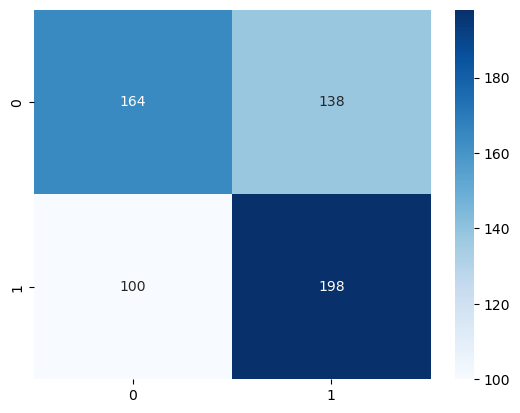

In [127]:
score_model(model.predict(X_test), y_test)

In [110]:
import pickle 

In [128]:
with open("../Models/AnswerabilityModel1.pkl", "wb") as f:
    pickle.dump(model, f)

In [55]:
bool(1)

True

In [59]:
!pip install graphviz

  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [57]:
import matplotlib.pyplot as plt
import xgboost as xgb

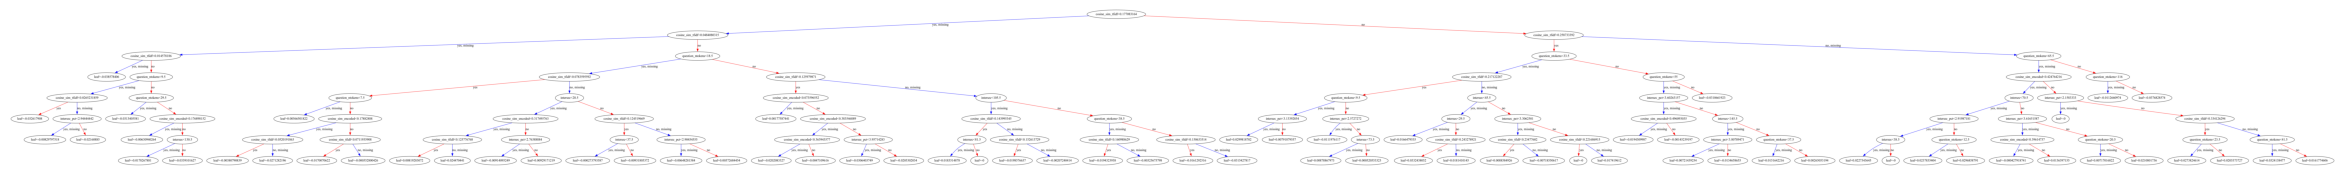

In [60]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, num_trees=1, ax=ax)
plt.show()

In [62]:
model.get_booster().get_score(importance_type='weight')

{'question_ntokens': 972.0,
 'review_ntokens': 888.0,
 'intersec': 929.0,
 'intersec_pct': 829.0,
 'cosine_sim_encoded': 976.0,
 'dot_prod_encoded': 283.0,
 'euclid_dist_encoded': 78.0,
 'cosine_sim_tfidf': 1101.0,
 'dot_prod_tfidf': 482.0,
 'euclid_dist_tfidf': 52.0}

<AxesSubplot: xlabel='questionText', ylabel='Count'>

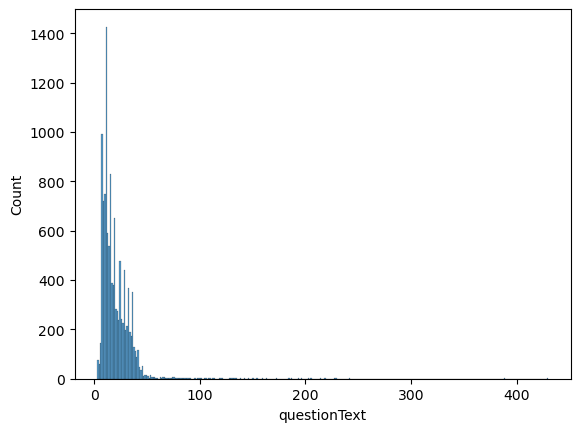

In [64]:
sns.histplot(df['Question'].apply(lambda x: len(tokenizer.encode(x))))

In [65]:
df['Question'].apply(lambda x: len(tokenizer.encode(x))).describe()

count    12000.000000
mean        20.022500
std         15.208192
min          3.000000
25%         11.000000
50%         16.000000
75%         26.000000
max        430.000000
Name: questionText, dtype: float64